<a href="https://colab.research.google.com/github/Grantar-alt/evol_methods/blob/main/Evol_methods_Base_on.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Базовый запуск (один прогон + график на каждом поколении)

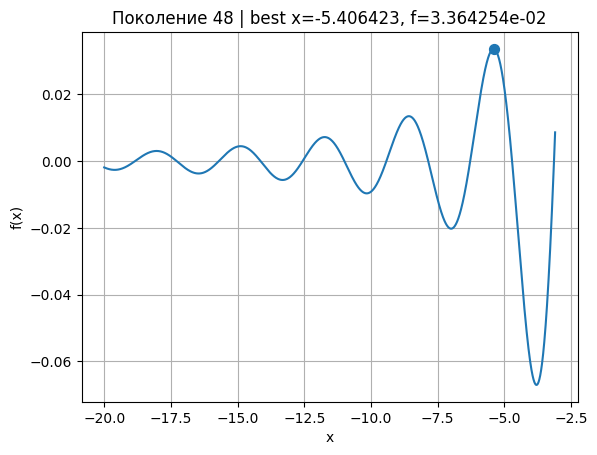

ИТОГ:
      best_x: -5.406423098013972
      best_f: 0.03364254013907153
 generations: 48
    time_sec: 17.559824516000006
      x_true: -5.406318425273701
      f_true: 0.03364254062752799
       err_x: 0.00010467274027092799
       err_f: 4.884564627771759e-10


In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# =========================
# 1) Индивидуальное задание
# =========================
A, B = -20.0, -3.1  # интервал (вариант 4)
def f(x: np.ndarray) -> np.ndarray:
    # x не содержит 0, но на всякий случай защищаемся
    x = np.asarray(x, dtype=float)
    return np.sin(2.0 * x) / (x**2 + 1e-18)

# ==========================================================
# 2) Двоичное кодирование: битовая строка -> вещественное x
# ==========================================================
def bits_to_int(bits: np.ndarray) -> np.ndarray:
    # bits: (N, L) из 0/1
    L = bits.shape[1]
    weights = (1 << np.arange(L-1, -1, -1, dtype=np.uint64))  # 2^(L-1) ... 2^0
    return (bits * weights).sum(axis=1).astype(np.uint64)

def decode(bits: np.ndarray, a: float, b: float) -> np.ndarray:
    L = bits.shape[1]
    m = (1 << L) - 1  # 2^L - 1
    ints = bits_to_int(bits).astype(np.float64)
    return a + (ints / m) * (b - a)

# ==========================================================
# 3) Оператор репродукции: рулетка (пропорциональный отбор)
# ==========================================================
def roulette_selection(rng: np.random.Generator, fitness: np.ndarray, n_select: int) -> np.ndarray:
    # roulette требует неотрицательные значения
    fit = fitness.copy()
    fit -= fit.min()
    fit += 1e-12  # чтобы суммы/вероятности не обнулились
    p = fit / fit.sum()
    return rng.choice(len(fitness), size=n_select, replace=True, p=p)

# ==========================================================
# 4) Операторы кроссинговера и мутации
# ==========================================================
def one_point_crossover(rng: np.random.Generator, p1: np.ndarray, p2: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    # p1, p2: (L,)
    L = p1.shape[0]
    k = rng.integers(1, L)  # точка разрыва: 1..L-1
    c1 = np.concatenate([p1[:k], p2[k:]])
    c2 = np.concatenate([p2[:k], p1[k:]])
    return c1, c2

def mutate_bitflip(rng: np.random.Generator, child: np.ndarray, pm: float) -> np.ndarray:
    # инверсия бита с вероятностью pm
    mask = rng.random(child.shape[0]) < pm
    child = child.copy()
    child[mask] = 1 - child[mask]
    return child

# ==========================================================
# 5) Простой ГА (с расширением+редукцией = элитистский отбор лучших)
# ==========================================================
def simple_ga(
    *,
    seed: int = 42,
    L: int = 20,            # длина хромосомы (бит)
    N: int = 80,            # мощность популяции
    Pc: float = 0.85,       # вероятность кроссинговера
    Pm: float = 0.001,      # вероятность мутации (на бит)
    max_gen: int = 200,
    stall_gen: int = 30,    # ранняя остановка: сколько поколений нет улучшения
    plot_each_gen: bool = True,
):
    rng = np.random.default_rng(seed)

    # начальная популяция: (N, L)
    pop = rng.integers(0, 2, size=(N, L), dtype=np.int8)

    # для "действительного" решения сделаем плотный поиск (эталон)
    grid = np.linspace(A, B, 250_000)
    y_grid = f(grid)
    true_idx = int(np.argmax(y_grid))
    x_true, f_true = float(grid[true_idx]), float(y_grid[true_idx])

    best_f = -np.inf
    best_x = None
    best_bits = None
    best_hist = []
    t0 = time.perf_counter()

    no_improve = 0

    # подготовим график функции для отрисовки
    if plot_each_gen:
        xg = np.linspace(A, B, 2000)
        yg = f(xg)

    for gen in range(1, max_gen + 1):
        # фенотипы и целевая функция
        xs = decode(pop, A, B)
        ys = f(xs)  # так как максимум

        # фиксируем лучшее
        idx = int(np.argmax(ys))
        if ys[idx] > best_f + 1e-12:
            best_f = float(ys[idx])
            best_x = float(xs[idx])
            best_bits = pop[idx].copy()
            no_improve = 0
        else:
            no_improve += 1

        best_hist.append(best_f)

        # визуализация: функция + лучшая точка на текущем поколении
        if plot_each_gen:
            clear_output(wait=True)
            plt.figure()
            plt.plot(xg, yg)
            plt.scatter([best_x], [best_f], s=50)
            plt.title(f"Поколение {gen} | best x={best_x:.6f}, f={best_f:.6e}")
            plt.xlabel("x")
            plt.ylabel("f(x)")
            plt.grid(True)
            plt.show()

        # критерий ранней остановки
        if no_improve >= stall_gen:
            break

        # ----------- Эволюционные операторы -----------
        # 1) Репродукция (рулетка) -> выбираем родителей
        parent_idx = roulette_selection(rng, ys, N)
        parents = pop[parent_idx]

        # 2) Кроссинговер+мутация -> формируем потомков
        children = []
        for i in range(0, N, 2):
            p1 = parents[i]
            p2 = parents[(i + 1) % N]
            if rng.random() < Pc:
                c1, c2 = one_point_crossover(rng, p1, p2)
            else:
                c1, c2 = p1.copy(), p2.copy()
            c1 = mutate_bitflip(rng, c1, Pm)
            c2 = mutate_bitflip(rng, c2, Pm)
            children.append(c1)
            children.append(c2)
        children = np.asarray(children[:N], dtype=np.int8)

        # 3) Расширение + редукция: объединяем pop и children, оставляем лучших N
        combined = np.vstack([pop, children])
        x_comb = decode(combined, A, B)
        y_comb = f(x_comb)
        best_idx = np.argsort(-y_comb)[:N]  # сортировка по убыванию
        pop = combined[best_idx]

    elapsed = time.perf_counter() - t0

    # итоговая точность относительно "действительного" решения
    err_x = abs(best_x - x_true)
    err_f = abs(best_f - f_true)

    result = {
        "best_x": best_x,
        "best_f": best_f,
        "best_bits": best_bits,
        "generations": gen,
        "time_sec": elapsed,
        "x_true": x_true,
        "f_true": f_true,
        "err_x": err_x,
        "err_f": err_f,
        "history_best_f": np.array(best_hist, dtype=float),
    }
    return result

res = simple_ga(
    seed=1,
    L=20,
    N=80,
    Pc=0.85,
    Pm=0.001,
    max_gen=200,
    stall_gen=30,
    plot_each_gen=True
)

print("ИТОГ:")
for k in ["best_x","best_f","generations","time_sec","x_true","f_true","err_x","err_f"]:
    print(f"{k:>12}: {res[k]}")


Эксперименты по $N,\; P_c,\; P_m$ (таблица + графики)

,N,Pc,Pm,seed,best_x,best_f,gens,time_sec,err_x,err_f
0,20,0.6,0.0005,1,-8.909445,0.010804,46,0.183172,3.503127,0.022838
1,20,0.6,0.0005,2,-5.811188,0.023983,34,0.164218,0.404870,0.009659
2,20,0.6,0.0005,3,-5.402152,0.033641,200,0.664107,0.004166,0.000001
3,20,0.6,0.0005,4,-5.340843,0.033345,54,0.081096,0.065476,0.000298
4,20,0.6,0.0005,5,-5.334847,0.033287,52,0.107667,0.071471,0.000355


,N,Pc,Pm,runs,best_f_mean,best_f_std,err_x_mean,err_x_std,gens_mean,gens_std,time_mean,time_std
35,150,0.95,0.0100,5,0.033643,0.000000e+00,0.000024,0.000000,41.4,2.701851,0.101077,0.014366
32,150,0.80,0.0100,5,0.033642,5.424789e-07,0.000869,0.001879,44.8,1.923538,0.119542,0.023719
33,150,0.95,0.0005,5,0.033642,5.423912e-07,0.000898,0.001864,47.0,9.460444,0.237995,0.148319
34,150,0.95,0.0010,5,0.033642,6.415262e-07,0.001668,0.002252,45.6,7.300685,0.104990,0.014406
29,150,0.60,0.0100,5,0.033642,6.643317e-07,0.001726,0.002287,43.4,3.847077,0.160362,0.011623
20,80,0.60,0.0100,5,0.033642,6.642444e-07,0.001739,0.002275,45.0,4.062019,0.050986,0.002731
24,80,0.95,0.0005,5,0.033642,6.644178e-07,0.002545,0.002308,71.2,42.079686,0.095072,0.059832
28,150,0.60,0.0010,5,0.033642,6.642908e-07,0.002564,0.002282,48.4,9.555103,0.183473,0.051636
27,150,0.60,0.0005,5,0.033642,6.642270e-07,0.002567,0.002278,49.4,11.126545,0.122417,0.047231
31,150,0.80,0.0010,5,0.033642,5.341527e-07,0.003354,0.001854,47.0,7.314369,0.109183,0.015043


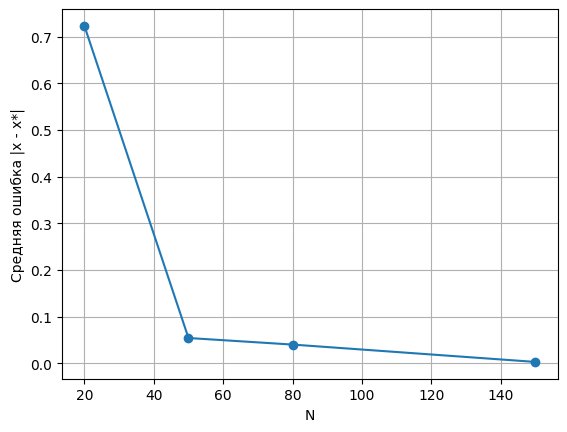

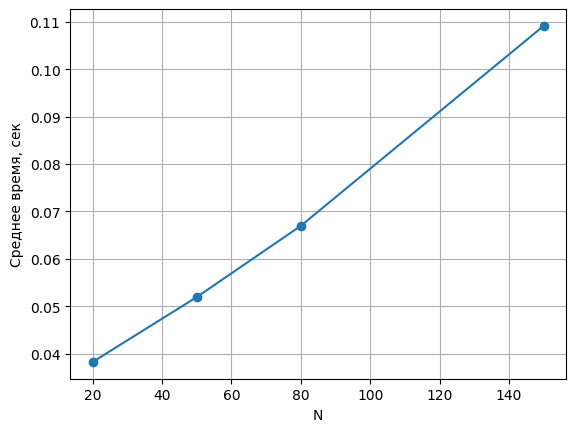

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def run_grid(
    N_list=(20, 50, 80, 150),
    Pc_list=(0.6, 0.8, 0.95),
    Pm_list=(0.0005, 0.001, 0.01),
    L=20,
    max_gen=200,
    stall_gen=30,
    seeds=(1, 2, 3, 4, 5),
):
    rows = []
    for N in N_list:
        for Pc in Pc_list:
            for Pm in Pm_list:
                for seed in seeds:
                    r = simple_ga(
                        seed=seed, L=L, N=N, Pc=Pc, Pm=Pm,
                        max_gen=max_gen, stall_gen=stall_gen,
                        plot_each_gen=False
                    )
                    rows.append({
                        "N": N, "Pc": Pc, "Pm": Pm, "seed": seed,
                        "best_x": r["best_x"], "best_f": r["best_f"],
                        "gens": r["generations"], "time_sec": r["time_sec"],
                        "err_x": r["err_x"], "err_f": r["err_f"],
                    })
    df = pd.DataFrame(rows)
    return df

df = run_grid()
display(df.head())

# Агрегация (то, что удобно вставлять в отчёт таблицей)
agg = df.groupby(["N","Pc","Pm"]).agg(
    runs=("seed","count"),
    best_f_mean=("best_f","mean"),
    best_f_std=("best_f","std"),
    err_x_mean=("err_x","mean"),
    err_x_std=("err_x","std"),
    gens_mean=("gens","mean"),
    gens_std=("gens","std"),
    time_mean=("time_sec","mean"),
    time_std=("time_sec","std"),
).reset_index()

display(agg.sort_values(["err_x_mean","time_mean"]).head(15))

# Мини-графики для отчёта: влияние N при фиксированных Pc,Pm (пример)
fixed_Pc, fixed_Pm = 0.8, 0.001
slice_ = agg[(agg["Pc"]==fixed_Pc) & (agg["Pm"]==fixed_Pm)].sort_values("N")

plt.figure()
plt.plot(slice_["N"], slice_["err_x_mean"], marker="o")
plt.xlabel("N")
plt.ylabel("Средняя ошибка |x - x*|")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(slice_["N"], slice_["time_mean"], marker="o")
plt.xlabel("N")
plt.ylabel("Среднее время, сек")
plt.grid(True)
plt.show()
